# # EE769 Assignment-3 
**Mirza Aman Baig(213230007)  
Rohan Appaso More(213230013)**

**Question No. 1**

 The code is about “ConvNet as fixed feature extractor” for classifying ants vs bees. And is given by Sasank (CTO of Qure.ai, pytorch contributor, and alumnus of IITB)  
 https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  
  The key feature of this code is that it does not train a model from scratch, but uses 
transfer learning of a ResNet-18 architecture that is pre-trained on a large dataset 
(ImageNet) and then only fine-tunes it for the problem at hand.

In this question we will try to train and visualize the model. And try to find the validation loss and validation accuracy for upto 25 epochs. We will introduce weight and try to find best weight decay factor.

In [41]:
#importing some important useful libraries
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

When using google colab try to use below code and mount with your google drive and change the content drive

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
cd  /content/drive/MyDrive/hymenoptera_data

/content/drive/MyDrive/hymenoptera_data


when using jupyter notebook try to use this code to access the data

In [44]:
# cd C:\\Users\\rohan\\Downloads\\213230013_213230007_3

In [45]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Visualize a few Images**

Let’s visualize a few training images so as to understand the data augmentations

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


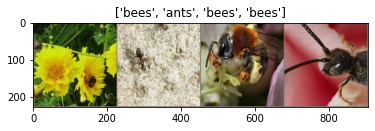

In [46]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model

In [47]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    valLoss = []
    valAcc = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'val':       # to store validation loss and accuracy
                valLoss.append(epoch_loss)
                valAcc.append(epoch_acc)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,valLoss,valAcc

# Visualizing the model predictions

Generic function to display predictions for a few images

In [48]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#Finetuning the convnet

Load a pretrained model and reset final fully connected layer.

In [49]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

**Train and evaluate for 25 epochs**

In [50]:
model_ft,valLoss,valAcc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5353 Acc: 0.7377
val Loss: 0.1801 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.5868 Acc: 0.7459
val Loss: 0.2143 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.6439 Acc: 0.7623
val Loss: 0.2584 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.3554 Acc: 0.8484
val Loss: 0.2799 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.4339 Acc: 0.8238
val Loss: 0.2860 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.3770 Acc: 0.8402
val Loss: 0.3369 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.4451 Acc: 0.8443
val Loss: 0.4466 Acc: 0.8235

Epoch 7/24
----------
train Loss: 0.3423 Acc: 0.8648
val Loss: 0.2646 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.2950 Acc: 0.8648
val Loss: 0.2152 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2904 Acc: 0.8852
val Loss: 0.2348 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2661 Acc: 0.9016
val Loss: 0.2086 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3350 Acc: 0.8689
val Loss: 0.2015 Acc: 0.9216

Epoch 12/24
----------
t

In [51]:
print(valLoss,valAcc)

[0.1800859403230396, 0.21429155471132083, 0.25844423151331547, 0.279947660802719, 0.285996043576792, 0.3368811786320864, 0.4466342041250517, 0.2646074808062681, 0.21524925161479497, 0.2348050309186862, 0.20859847736417078, 0.2015215913503388, 0.250621691547042, 0.2225387672729352, 0.25102101894874684, 0.23698975033662434, 0.20941598678701648, 0.21281575855305968, 0.22500274453526728, 0.19936160394142755, 0.1996046730714357, 0.20424589008287666, 0.19980873725699638, 0.20288291063807978, 0.20390132580902062] [tensor(0.9346, dtype=torch.float64), tensor(0.9216, dtype=torch.float64), tensor(0.9085, dtype=torch.float64), tensor(0.8954, dtype=torch.float64), tensor(0.9216, dtype=torch.float64), tensor(0.9085, dtype=torch.float64), tensor(0.8235, dtype=torch.float64), tensor(0.9020, dtype=torch.float64), tensor(0.9150, dtype=torch.float64), tensor(0.9216, dtype=torch.float64), tensor(0.9281, dtype=torch.float64), tensor(0.9216, dtype=torch.float64), tensor(0.9020, dtype=torch.float64), tensor

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


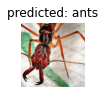

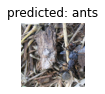

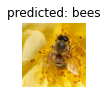

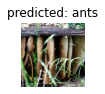

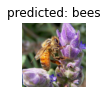

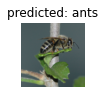

In [52]:
visualize_model(model_ft)

# ConvNet as fixed feature extractor

In [53]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [54]:
model_conv,valLoss,valAcc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5469 Acc: 0.7254
val Loss: 0.4256 Acc: 0.8170

Epoch 1/24
----------
train Loss: 0.5001 Acc: 0.7992
val Loss: 0.2940 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4055 Acc: 0.8156
val Loss: 0.1822 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.6605 Acc: 0.7172
val Loss: 0.2660 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.8818 Acc: 0.7213
val Loss: 0.1875 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.5685 Acc: 0.7869
val Loss: 0.3262 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.4654 Acc: 0.7869
val Loss: 0.2759 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3759 Acc: 0.8607
val Loss: 0.1734 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3576 Acc: 0.8607
val Loss: 0.2127 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.4042 Acc: 0.8320
val Loss: 0.1985 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3584 Acc: 0.8279
val Loss: 0.2139 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3524 Acc: 0.8730
val Loss: 0.1941 Acc: 0.9216

Epoch 12/24
----------
t

In [55]:
print(valLoss,valAcc)

[0.42556605643891043, 0.29402240035824134, 0.1821781898075654, 0.26596685075863064, 0.18750310978346985, 0.32620572952973637, 0.2759070398523381, 0.17344095466317597, 0.21269487100767484, 0.19854997169360325, 0.21393733485175748, 0.19414053449492438, 0.18368120377372002, 0.19486805262634518, 0.17445768867893255, 0.21852518982722674, 0.2227819816512208, 0.20108468372456947, 0.1817673536354609, 0.22461429731981233, 0.18788538218568707, 0.17899730492358892, 0.1813265395326406, 0.19563927791184849, 0.171070659408358] [tensor(0.8170, dtype=torch.float64), tensor(0.8954, dtype=torch.float64), tensor(0.9412, dtype=torch.float64), tensor(0.9150, dtype=torch.float64), tensor(0.9477, dtype=torch.float64), tensor(0.8627, dtype=torch.float64), tensor(0.8954, dtype=torch.float64), tensor(0.9412, dtype=torch.float64), tensor(0.9346, dtype=torch.float64), tensor(0.9412, dtype=torch.float64), tensor(0.9281, dtype=torch.float64), tensor(0.9216, dtype=torch.float64), tensor(0.9346, dtype=torch.float64),

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


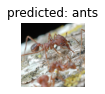

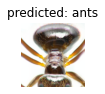

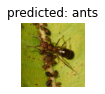

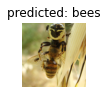

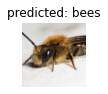

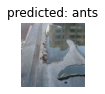

In [56]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [57]:
epo = []
for i in range(25):
  epo.append(i)

In [58]:
print(valLoss)

[0.42556605643891043, 0.29402240035824134, 0.1821781898075654, 0.26596685075863064, 0.18750310978346985, 0.32620572952973637, 0.2759070398523381, 0.17344095466317597, 0.21269487100767484, 0.19854997169360325, 0.21393733485175748, 0.19414053449492438, 0.18368120377372002, 0.19486805262634518, 0.17445768867893255, 0.21852518982722674, 0.2227819816512208, 0.20108468372456947, 0.1817673536354609, 0.22461429731981233, 0.18788538218568707, 0.17899730492358892, 0.1813265395326406, 0.19563927791184849, 0.171070659408358]


**Note :** while using the GPU for fast results I was getting the error while plotting the figure of validation loss vs validation accuracy

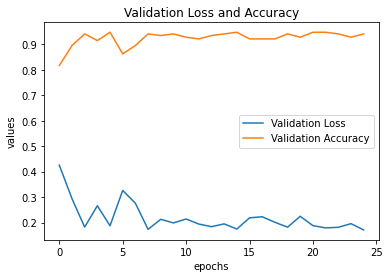

In [59]:
import matplotlib.pyplot as plt


plt.plot(epo, valLoss, label = "Validation Loss")
plt.plot(epo, valAcc, label = "Validation Accuracy")

plt.xlabel('epochs')
plt.ylabel('values')
plt.title('Validation Loss and Accuracy')
plt.legend()

plt.show()

while looking at figure we can see that Validation accuracy goes on increasing and validation loss goes on decreasing with epochs which is great for our trained model

In [60]:
##############
##############
##############
##############

# Changing the learning rate, momentum, and number of epochs

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6869 Acc: 0.6230
val Loss: 0.4210 Acc: 0.8235

Epoch 1/14
----------
train Loss: 0.5275 Acc: 0.7377
val Loss: 0.4389 Acc: 0.7908

Epoch 2/14
----------
train Loss: 0.4792 Acc: 0.7705
val Loss: 0.3659 Acc: 0.8431

Epoch 3/14
----------
train Loss: 0.4420 Acc: 0.7705
val Loss: 0.2412 Acc: 0.9412

Epoch 4/14
----------
train Loss: 0.4202 Acc: 0.8074
val Loss: 0.2005 Acc: 0.9477

Epoch 5/14
----------
train Loss: 0.3938 Acc: 0.8156
val Loss: 0.1977 Acc: 0.9542

Epoch 6/14
----------
train Loss: 0.3739 Acc: 0.8443
val Loss: 0.1960 Acc: 0.9542

Epoch 7/14
----------
train Loss: 0.3119 Acc: 0.8607
val Loss: 0.1984 Acc: 0.9542

Epoch 8/14
----------
train Loss: 0.3742 Acc: 0.8156
val Loss: 0.1938 Acc: 0.9477

Epoch 9/14
----------
train Loss: 0.3701 Acc: 0.8197
val Loss: 0.1982 Acc: 0.9477

Epoch 10/14
----------
train Loss: 0.3428 Acc: 0.8320
val Loss: 0.1979 Acc: 0.9412

Epoch 11/14
----------
train Loss: 0.3671 Acc: 0.8402
val Loss: 0.1852 Acc: 0.9477

Epoch 12/14
----------
t

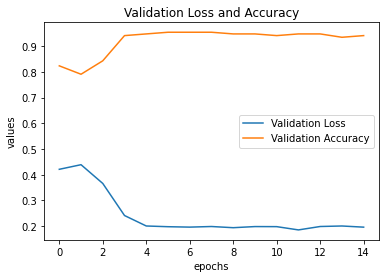

In [61]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.003, momentum=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
######
#####
model_conv,valLoss,valAcc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=15)

epo = []
for i in range(15):
  epo.append(i)

import matplotlib.pyplot as plt

plt.plot(epo, valLoss, label = "Validation Loss")
plt.plot(epo, valAcc, label = "Validation Accuracy")

plt.xlabel('epochs')
plt.ylabel('values')
plt.title('Validation Loss and Accuracy')
plt.legend()

plt.show()

When momentum is low after some epoch we are getting constant validatio accuracy and validation loss

The above plot is for  
learning rate = 0.003  
momentum=0.1  
Number of epochs=15

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7010 Acc: 0.6066
val Loss: 0.2378 Acc: 0.9216

Epoch 1/19
----------
train Loss: 0.4550 Acc: 0.7746
val Loss: 0.2432 Acc: 0.9150

Epoch 2/19
----------
train Loss: 0.5471 Acc: 0.7623
val Loss: 0.2406 Acc: 0.8954

Epoch 3/19
----------
train Loss: 0.4838 Acc: 0.7910
val Loss: 0.3029 Acc: 0.9020

Epoch 4/19
----------
train Loss: 0.4748 Acc: 0.7910
val Loss: 0.1725 Acc: 0.9412

Epoch 5/19
----------
train Loss: 0.4144 Acc: 0.8361
val Loss: 0.2212 Acc: 0.9346

Epoch 6/19
----------
train Loss: 0.5244 Acc: 0.8033
val Loss: 0.1595 Acc: 0.9542

Epoch 7/19
----------
train Loss: 0.3613 Acc: 0.8402
val Loss: 0.1572 Acc: 0.9477

Epoch 8/19
----------
train Loss: 0.3430 Acc: 0.8484
val Loss: 0.1554 Acc: 0.9608

Epoch 9/19
----------
train Loss: 0.3371 Acc: 0.8361
val Loss: 0.1659 Acc: 0.9608

Epoch 10/19
----------
train Loss: 0.3406 Acc: 0.8361
val Loss: 0.1758 Acc: 0.9608

Epoch 11/19
----------
train Loss: 0.3429 Acc: 0.8566
val Loss: 0.1597 Acc: 0.9608

Epoch 12/19
----------
t

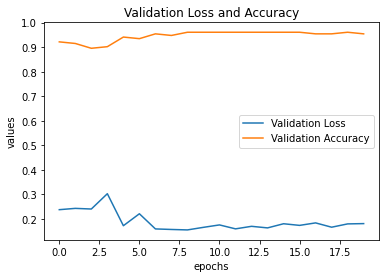

In [62]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.005, momentum=0.4)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
######
#####
model_conv,valLoss,valAcc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

epo = []
for i in range(20):
  epo.append(i)

import matplotlib.pyplot as plt

plt.plot(epo, valLoss, label = "Validation Loss")
plt.plot(epo, valAcc, label = "Validation Accuracy")

plt.xlabel('epochs')
plt.ylabel('values')
plt.title('Validation Loss and Accuracy')
plt.legend()

plt.show()

The above plot is for  
learning rate = 0.005  
momentum=0.4  
Number of epochs=20

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8991 Acc: 0.7008
val Loss: 0.3998 Acc: 0.8693

Epoch 1/9
----------
train Loss: 0.6914 Acc: 0.7623
val Loss: 0.2195 Acc: 0.9477

Epoch 2/9
----------
train Loss: 0.5351 Acc: 0.8238
val Loss: 0.5055 Acc: 0.8758

Epoch 3/9
----------
train Loss: 0.8728 Acc: 0.7787
val Loss: 0.4025 Acc: 0.9085

Epoch 4/9
----------
train Loss: 1.1465 Acc: 0.7910
val Loss: 0.2764 Acc: 0.9542

Epoch 5/9
----------
train Loss: 1.5695 Acc: 0.7500
val Loss: 0.2890 Acc: 0.9542

Epoch 6/9
----------
train Loss: 1.1255 Acc: 0.7992
val Loss: 0.2742 Acc: 0.9477

Epoch 7/9
----------
train Loss: 0.4140 Acc: 0.8811
val Loss: 0.3564 Acc: 0.9281

Epoch 8/9
----------
train Loss: 0.3902 Acc: 0.8811
val Loss: 0.2826 Acc: 0.9542

Epoch 9/9
----------
train Loss: 0.4025 Acc: 0.8811
val Loss: 0.3400 Acc: 0.9346

Training complete in 5m 51s
Best val Acc: 0.954248


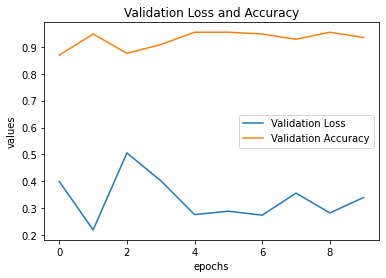

In [63]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.7)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
######
#####
model_conv,valLoss,valAcc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

epo = []
for i in range(10):
  epo.append(i)

import matplotlib.pyplot as plt

plt.plot(epo, valLoss, label = "Validation Loss")
plt.plot(epo, valAcc, label = "Validation Accuracy")

plt.xlabel('epochs')
plt.ylabel('values')
plt.title('Validation Loss and Accuracy')
plt.legend()

plt.show()

The above plot is for  
learning rate = 0.01  
momentum=0.7  
Number of epochs=10

from the above three plots of validation accuracy and loss we can see that as we increase the learning rate there is more variation in plot for epochs.  
And when the momenture value is low the accuracy is good and variation for each epoch is low.  
So it is best to keep low learning rate and low momentum

In [64]:

# # example of l2 on a convolutional layer
# from keras.layers import Conv2D
# from keras.regularizers import l2
# model_conv.parameters(Conv2D(32, (3,3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))


In [65]:
# model_conv.parameters

# Finding the best value for weigth decay factor

In [66]:
# NOW WE WILL FIND THE BEST  VALUE OF WEIGTH DECAY FACTOR

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6164 Acc: 0.6844
val Loss: 0.2195 Acc: 0.9542

Epoch 1/24
----------
train Loss: 0.5187 Acc: 0.7705
val Loss: 0.2128 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4173 Acc: 0.8197
val Loss: 0.2128 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.5083 Acc: 0.7869
val Loss: 0.2267 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4272 Acc: 0.8197
val Loss: 0.2138 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4917 Acc: 0.8115
val Loss: 0.1766 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.5063 Acc: 0.7746
val Loss: 0.2073 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3173 Acc: 0.8525
val Loss: 0.2111 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2817 Acc: 0.8811
val Loss: 0.1867 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3247 Acc: 0.8402
val Loss: 0.1965 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2896 Acc: 0.8811
val Loss: 0.2154 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2902 Acc: 0.8730
val Loss: 0.1866 Acc: 0.9477

Epoch 12/24
----------
t

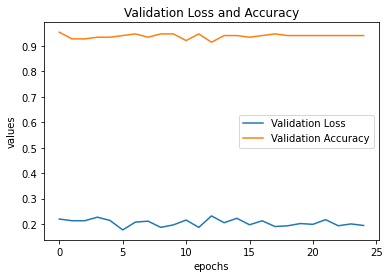

In [67]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9, weight_decay=0.02)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
###########
###########
model_conv,valLoss,valAcc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

epo = []
for i in range(25):
  epo.append(i)


  import matplotlib.pyplot as plt

plt.plot(epo, valLoss, label = "Validation Loss")
plt.plot(epo, valAcc, label = "Validation Accuracy")

plt.xlabel('epochs')
plt.ylabel('values')
plt.title('Validation Loss and Accuracy')
plt.legend()

plt.show()

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6191 Acc: 0.6721
val Loss: 0.2104 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.5068 Acc: 0.7992
val Loss: 0.3965 Acc: 0.8170

Epoch 2/24
----------
train Loss: 0.3703 Acc: 0.8074
val Loss: 0.1786 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4550 Acc: 0.7828
val Loss: 0.1671 Acc: 0.9608

Epoch 4/24
----------
train Loss: 0.3937 Acc: 0.8238
val Loss: 0.1669 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.5801 Acc: 0.7828
val Loss: 0.2059 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4894 Acc: 0.7828
val Loss: 0.1712 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.2746 Acc: 0.8811
val Loss: 0.1962 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3735 Acc: 0.8279
val Loss: 0.1657 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.4124 Acc: 0.8197
val Loss: 0.2042 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3380 Acc: 0.8361
val Loss: 0.2150 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2494 Acc: 0.9016
val Loss: 0.1731 Acc: 0.9608

Epoch 12/24
----------
t

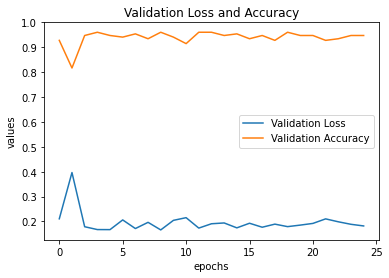

In [70]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
###########
###########
model_conv,valLoss,valAcc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

epo = []
for i in range(25):
  epo.append(i)


  import matplotlib.pyplot as plt

plt.plot(epo, valLoss, label = "Validation Loss")
plt.plot(epo, valAcc, label = "Validation Accuracy")

plt.xlabel('epochs')
plt.ylabel('values')
plt.title('Validation Loss and Accuracy')
plt.legend()

plt.show()

We used different values of weight decay from 0.01 to 0.1.
In the first case(0.01) our model takes more epochs to fit. In the second case(0.1) it works best. and for other cases also it makes fit between these two